In [1]:
!nvidia-smi

Wed Aug 26 14:42:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
10.6MB [00:00, 93.8MB/s]


In [3]:
!unzip -qq ECG5000.zip

replace ECG5000.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ECG5000_TEST.arff? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ECG5000_TEST.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ECG5000_TRAIN.arff? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ECG5000_TRAIN.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ECG5000_TEST.ts? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace ECG5000_TRAIN.ts? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [4]:
!pip install -qq arff2pandas

In [5]:
from arff2pandas import a2p
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [8]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

In [9]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [10]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

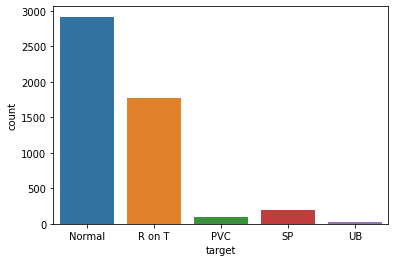

In [11]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

In [12]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

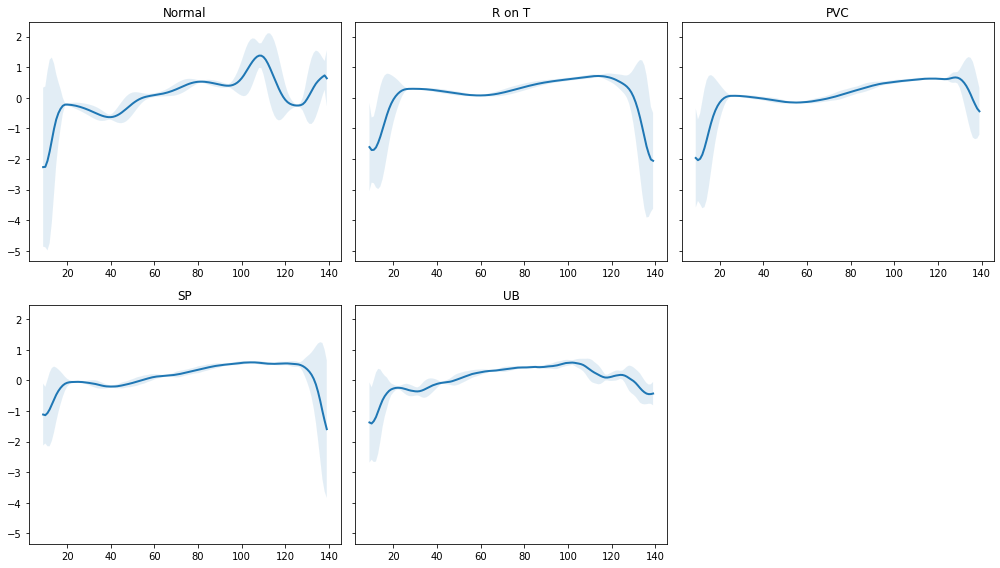

In [13]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls].drop(labels='target', axis=1).mean(axis=0).to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [14]:

normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [15]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [16]:
from sklearn.model_selection import train_test_split 
RANDOM_SEED = 42
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [17]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy()
  dataset = np.expand_dims(sequences, -1)
  n_seq, seq_len, n_features = dataset.shape
  return dataset, seq_len, n_features

In [18]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [19]:
class Encoder:

  def __init__(self, seq_len, n_features, embedding_dim=64):

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = keras.layers.LSTM(self.hidden_dim, return_sequences=True)
    self.rnn2 = keras.layers.LSTM(self.embedding_dim)

  def forward(self, x):
    # if input x is a vactor with shape as (None, seq_len , n_features)
    x = self.rnn1(x) 
    x = self.rnn2(x)
    return x  # (None(1), embedding_dim)

In [ ]:
class Decoder:

  def __init__(self, seq_len, input_dim=64, n_features=1):
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = keras.layers.LSTM(self.input_dim, return_sequences=True)
    self.rnn2 = keras.layers.LSTM(self.hidden_dim, return_sequences=True)
    self.output_layer = keras.layers.Dense(n_features)
  def forward(self, x):
    # input vactor x's shape is (1, input_dim) 
    x = keras.layers.RepeatVector(self.seq_len)(x) # reshape to (1, seq_len, input_dim)
    x = self.rnn1(x)  # (1, seq_len, input_dim)
    x = self.rnn2(x) # (1, seq_len, hidden_dim)
    x = self.output_layer(x) # (1, seq_len, n_features)
    return x

In [ ]:
class RecurrentAutoencoder:

  def __init__(self, seq_len, n_features, embedding_dim=64):
    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)
    self.seq_len = seq_len
    self.n_features = n_features
  def get_model(self):
    input_tensor = keras.layers.Input((self.seq_len, self.n_features))
    x = self.encoder.forward(input_tensor)
    x = self.decoder.forward(x)

    return keras.models.Model(input_tensor, x)  

In [ ]:
ra = RecurrentAutoencoder(seq_len, n_features, 128)
model = ra.get_model()

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 140, 256)          264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 140, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 140, 128)          131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 140, 256)          394240    
_________________________________________________________________
dense (Dense)                (None, 140, 1)           

In [ ]:
model.compile('adam', loss='mae')
history = model.fit(train_dataset, train_dataset, batch_size=64, epochs=10, verbose=1, validation_data=(val_dataset, val_dataset))
  

Epoch 1/10
39/39 [==============================] - 3s 74ms/step - loss: 0.3813 - val_loss: 0.3433
Epoch 2/10
39/39 [==============================] - 2s 43ms/step - loss: 0.3216 - val_loss: 0.3216
Epoch 3/10
39/39 [==============================] - 2s 43ms/step - loss: 0.2982 - val_loss: 0.2767
Epoch 4/10
39/39 [==============================] - 2s 43ms/step - loss: 0.3130 - val_loss: 0.2694
Epoch 5/10
39/39 [==============================] - 2s 43ms/step - loss: 0.2728 - val_loss: 0.3031
Epoch 6/10
39/39 [==============================] - 2s 43ms/step - loss: 0.2423 - val_loss: 0.2397
Epoch 7/10
39/39 [==============================] - 2s 44ms/step - loss: 0.2193 - val_loss: 0.1979
Epoch 8/10
39/39 [==============================] - 2s 43ms/step - loss: 0.2146 - val_loss: 0.1935
Epoch 9/10
39/39 [==============================] - 2s 44ms/step - loss: 0.1916 - val_loss: 0.1854
Epoch 10/10
39/39 [==============================] - 2s 44ms/step - loss: 0.2180 - val_loss: 0.1957


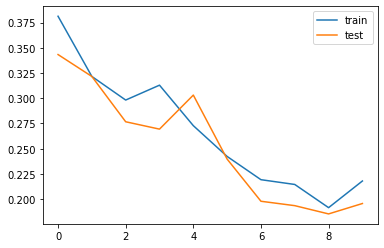

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

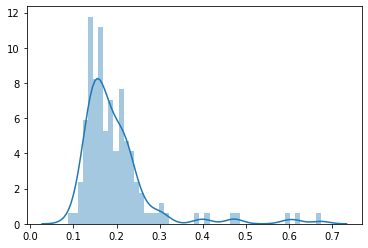

In [ ]:
pred_test_normal = model.predict(test_normal_dataset)
loss = np.mean(np.abs(test_normal_dataset-pred_test_normal), axis=1)
sns.distplot(loss, bins=50, kde=True)

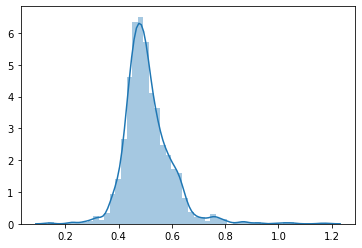

In [ ]:
pred_test_anomaly = model.predict(test_anomaly_dataset)
loss = np.mean(np.abs(test_anomaly_dataset-pred_test_anomaly), axis=1)
sns.distplot(loss, bins=50, kde=True)

In [ ]:
def plot_prediction(data, model, title, ax):
  data = np.expand_dims(data, 0)
  pred = model.predict(data)
  loss = np.mean(np.abs(data[0]-pred[0]))
  ax.plot(data[0], label='true')
  ax.plot(pred[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(loss, 2)})')
  ax.legend()

In [ ]:
def plot_prediction_demo(data, model, title, ax):
  a_initializer = np.zeros((1, 64))
  c_initializer = np.zeros((1, 64))
  data = np.expand_dims(data, 0) # [1, 140, 1]
  pred = model.predict([data, a_initializer, c_initializer])  # output list len=140 each element [1, 1]
  print(pred[0].shape)
  pred = np.swapaxes(np.array(pred), 0, 1)
  loss = np.mean(np.abs(data[0]-pred[0]))
  ax.plot(data[0], label='true')
  ax.plot(pred[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(loss, 2)})')
  ax.legend()

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  # plot_prediction(data, model, title='Normal', ax=axs[0, i])
  plot_prediction_demo(data, model_demo, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
  # plot_prediction(data, model, title='Anomaly', ax=axs[1, i])
  plot_prediction_demo(data, model_demo, title='Anomaly', ax=axs[1, i])
fig.tight_layout();

**   Try another model **

In [20]:
LSTM_CELL = keras.layers.LSTM(64, return_state=True)
reshapor = keras.layers.Reshape((1, 64))
densor = keras.layers.Dense(1)
def get_model():
  input_tensor = keras.layers.Input(shape=(140, 1))
  # encoding 
  x = keras.layers.LSTM(128, return_sequences=True)(input_tensor)   #  (None, 140, 128)
  x = keras.layers.LSTM(64, return_sequences=False)(x)   #  (None, 64)
  # decoding
  decode_tensor = []
  a0 = keras.layers.Input(shape=(64,), name='a0')
  c0 = keras.layers.Input(shape=(64,), name='c0')
  a = a0
  c = c0
  for t in range(140):
    x = reshapor(x)
    x, h, c = LSTM_CELL(x, initial_state=[a, c])  # x (None, 64) h (None, 64)
    out = densor(h)  # (None, 1)
    decode_tensor.append(out)
  
  # decode_tensor shape: (140, None, 1)

  model = keras.models.Model(inputs=[input_tensor, a0, c0], outputs=decode_tensor)
  return model

In [21]:
model_demo = get_model()
model_demo.summary()
model_demo.compile('adam', loss='mae')


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 140, 128)     66560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 64)           49408       lstm_1[0][0]                     
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 64)        0           lstm_2[0][0]                     
                                                                 lstm[0][0]            

In [22]:
# demo train
batch_size = 64
a0 = np.zeros((batch_size, 64))
c0 = np.zeros((batch_size, 64))
X = train_dataset[0:batch_size]
Y = list(np.swapaxes(X, 0, 1))
if X is not None and Y is not None:
  model_demo.fit([X, a0, c0], Y, verbose=1)
      
  Y_ = model_demo.predict([X, a0, c0])
  loss = 0
  for y, y_ in zip(Y, Y_):
    loss += np.mean(np.abs(y-y_))
  loss /= batch_size
  print(f'epoch:{e}, batch:{i}, loss:{loss}')

2/2 [==============================] - 1s 295ms/step - loss: 95.0226 - dense_loss: 0.9818 - dense_1_loss: 2.3265 - dense_2_loss: 3.3260 - dense_3_loss: 3.9635 - dense_4_loss: 3.8532 - dense_5_loss: 3.1970 - dense_6_loss: 2.2366 - dense_7_loss: 1.6548 - dense_8_loss: 1.2223 - dense_9_loss: 0.6198 - dense_10_loss: 0.3539 - dense_11_loss: 0.3580 - dense_12_loss: 0.3436 - dense_13_loss: 0.3398 - dense_14_loss: 0.3317 - dense_15_loss: 0.3302 - dense_16_loss: 0.3310 - dense_17_loss: 0.3398 - dense_18_loss: 0.3635 - dense_19_loss: 0.3728 - dense_20_loss: 0.3958 - dense_21_loss: 0.4133 - dense_22_loss: 0.4389 - dense_23_loss: 0.4710 - dense_24_loss: 0.4848 - dense_25_loss: 0.5231 - dense_26_loss: 0.5441 - dense_27_loss: 0.5762 - dense_28_loss: 0.6109 - dense_29_loss: 0.6424 - dense_30_loss: 0.7080 - dense_31_loss: 0.7365 - dense_32_loss: 0.7595 - dense_33_loss: 0.7948 - dense_34_loss: 0.8230 - dense_35_loss: 0.8185 - dense_36_loss: 0.8230 - dense_37_loss: 0.8007 - dense_38_loss: 0.7677 - dense

NameError: ignored

In [23]:
batch_size = 64
epochs = 10
a0 = np.zeros((batch_size, 64))
c0 = np.zeros((batch_size, 64))
for e in range(epochs):
  for i in range(len(train_dataset)//batch_size):
    X = train_dataset[i * batch_size:(1+i)*batch_size]
    Y = list(np.swapaxes(X, 0, 1))

    model_demo.fit([X, a0, c0], Y, verbose=1)
    
    Y_ = model_demo.predict([X, a0, c0])
    loss = 0
    for y, y_ in zip(Y, Y_):
      loss += np.mean(np.abs(y-y_))
    loss /= batch_size
    print(f'epoch:{e}, batch:{i}, loss:{loss}')
  

2/2 [==============================] - 1s 328ms/step - loss: 94.5742 - dense_loss: 0.9741 - dense_1_loss: 2.3102 - dense_2_loss: 3.3122 - dense_3_loss: 3.9556 - dense_4_loss: 3.8503 - dense_5_loss: 3.1984 - dense_6_loss: 2.2416 - dense_7_loss: 1.6629 - dense_8_loss: 1.2330 - dense_9_loss: 0.6321 - dense_10_loss: 0.3634 - dense_11_loss: 0.3711 - dense_12_loss: 0.3579 - dense_13_loss: 0.3551 - dense_14_loss: 0.3473 - dense_15_loss: 0.3454 - dense_16_loss: 0.3472 - dense_17_loss: 0.3562 - dense_18_loss: 0.3802 - dense_19_loss: 0.3910 - dense_20_loss: 0.4138 - dense_21_loss: 0.4316 - dense_22_loss: 0.4584 - dense_23_loss: 0.4912 - dense_24_loss: 0.5052 - dense_25_loss: 0.5428 - dense_26_loss: 0.5645 - dense_27_loss: 0.5969 - dense_28_loss: 0.6311 - dense_29_loss: 0.6639 - dense_30_loss: 0.7295 - dense_31_loss: 0.7580 - dense_32_loss: 0.7810 - dense_33_loss: 0.8170 - dense_34_loss: 0.8452 - dense_35_loss: 0.8406 - dense_36_loss: 0.8444 - dense_37_loss: 0.8228 - dense_38_loss: 0.7898 - dense

In [24]:
def plot_prediction_demo(data, model, title, ax):
  a_initializer = np.zeros((1, 64))
  c_initializer = np.zeros((1, 64))
  data = np.expand_dims(data, 0) # [1, 140, 1]
  pred = model.predict([data, a_initializer, c_initializer])  # output list len=140 each element [1, 1]
  pred = np.swapaxes(np.array(pred), 0, 1)
  loss = np.mean(np.abs(data[0]-pred[0]))
  ax.plot(data[0], label='true')
  ax.plot(pred[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(loss, 2)})')
  ax.legend()

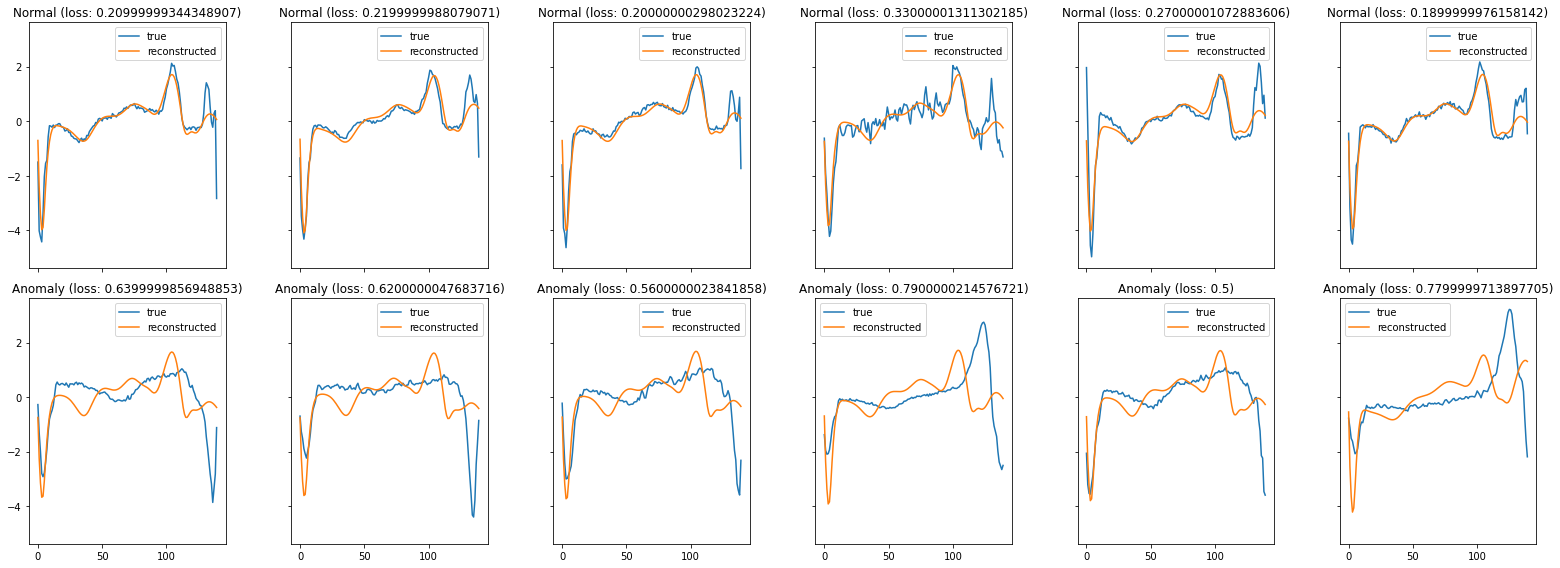

In [25]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction_demo(data, model_demo, title='Normal', ax=axs[0, i])
for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction_demo(data, model_demo, title='Anomaly', ax=axs[1, i])
fig.tight_layout();